In [225]:
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
%matplotlib inline

In [226]:
#combine everything from data/Standup into one csv file called standup.csv
# numread = 0
# with open('standup.csv', 'w') as outfile:
#     for fname in os.listdir('data/Standup'):
#         with open('data/Standup/'+fname) as infile:
#             #skip the first line if it's a header
#             if numread == 0:
#                 for line in infile:
#                     outfile.write(line)
#                     numread += 1
#             else: #only add the header once
#                 next(infile)
#                 for line in infile:
#                     outfile.write(line)
#             #add a newline after each file
#             outfile.write('\n')

    
            

In [227]:
class Sample:
    def __init__(self, label, processed_csv):
        #A sample contains the label name and the accelerometer (x,y,z) and gyroscope data (x,y,z) tuples
        #not necessary but its a bit more verbose to read than samples[label][0][0] for example
        self.label = label
        self.accelerometer = Sensor(processed_csv[0], processed_csv[1], processed_csv[2])
        self.gyroscope = Sensor(processed_csv[3], processed_csv[4], processed_csv[5])

class Sensor:
    def __init__(self, x, y, z):
        #again, not necessary but accessing it as accelerometer.x gives me the good brain chemicals
        self.x = np.array(x)
        self.y = np.array(y)
        self.z = np.array(z)
    def print_range(self, num):
        #prints the first num values of the sensor
        print(self.x[:num])
        print(self.y[:num])
        print(self.z[:num])

In [228]:
def clean_csv(csv_file):
    #get labels
    #we won't really need them since we know the order of the data but it's a sanity check
    labels = csv_file[0]
    #swap rows and columns, excluding the first row
    #this makes it so csv_file[0] is the first column, csv_file[1] is the second column, etc.
    #this makes it way more intuitive to access the data
    csv_file = [list(i) for i in zip(*csv_file[1:])] 
    
    for i in range(6): #we only have 6 columns, but the standing code had extras past that so I'm hard coding it. Sorry.
        #convert strings to floats
        for j in range(len(csv_file[i])):
            try:
                csv_file[i][j] = float(csv_file[i][j])
            except:
                print("Error converting to float: " + str(csv_file[i][j]))

    return labels, csv_file


In [229]:
#we need to load the csvs but standup is contained in a folder since it would be harder to splice since standing happens at variable times
basedir = "data/"
labels = ["standup", "climbing_down", "climbing_up", "walking", "still"]
#we will break our data into 50 samples per label (since standup is not logically divisible or concatenable and it has 50 samples
#this means that the other samples, which are in a single file each, will be need to be roughly split into 50 samples each
data = [] #normally we seperate based on label but the Sample class stores that so we can deal with it later and just dump everything in here
for label in labels:
    if label == "standup":
        for filename in os.listdir(basedir+label):
            if filename.endswith(".csv"):
                with open(basedir+label+"/"+filename, 'r') as f:
                    reader = csv.reader(f)
                    csv_file = list(reader)
                    x, csv_file = clean_csv(csv_file)
                    new_sample = Sample(label, csv_file)
                    data.append(new_sample)
                    # print_csv(csv_file)
    else:
        with open(basedir+label+".csv", 'r') as f:
            reader = csv.reader(f)
            csv_file = list(reader)
            x, csv_file = clean_csv(csv_file)
            for i in range(50): #split into 50 samples
                #the exact length of the csv's will vary so we need to use split it into 50 and discard the remainder
                # print(i, "start:stop", i*(len(whole_csv_file)-1)//50, (i+1)*(len(whole_csv_file)-1)//50)
                index_range = range(i*(len(csv_file[0]))//50,(i+1)*(len(csv_file[0])//50))
                #because I swapped rows and columns, accessing the data is gross
                #this code is getting the window of data we want using that index range
                new_sample = Sample(label, [csv_file[0][index_range[0]:index_range[-1]], csv_file[1][index_range[0]:index_range[-1]], csv_file[2][index_range[0]:index_range[-1]], csv_file[3][index_range[0]:index_range[-1]], csv_file[4][index_range[0]:index_range[-1]], csv_file[5][index_range[0]:index_range[-1]]])
                data.append(new_sample)
                
                

#now we have all of our data in a list of Sample objects
print("data length:", len(data)) #should be 50*#labels - sanity check
           

data length: 250


In [230]:
#lets print some random label data
# for x in range (5):
#     sample = data[np.random.randint(0, len(data))]
#     print("label:", sample.label)
#     sample.accelerometer.print_range(5)
#     sample.gyroscope.print_range(5)

In [231]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

import pandas as pd
import seaborn as sns

In [232]:
#function structure taken from Assignment 1 - task 2
def featurize_input(data) -> np.array:
    out = []
    for sample in data:
        fv = []
        fv.append(np.ptp(sample.accelerometer.x))
        fv.append(np.ptp(sample.accelerometer.y))
        fv.append(np.ptp(sample.accelerometer.z))
        fv.append(np.std(sample.accelerometer.x))
        fv.append(np.std(sample.accelerometer.y))
        fv.append(np.std(sample.accelerometer.z))
        fv.append(np.mean(sample.accelerometer.x))
        fv.append(np.mean(sample.accelerometer.y))
        fv.append(np.mean(sample.accelerometer.z))
        fv.append(np.median(sample.accelerometer.x))
        fv.append(np.median(sample.accelerometer.y))
        fv.append(np.median(sample.accelerometer.z))
        
        fv.append(np.mean(sample.gyroscope.x))
        fv.append(np.mean(sample.gyroscope.y))
        fv.append(np.mean(sample.gyroscope.z))
        fv.append(np.ptp(sample.gyroscope.x))
        fv.append(np.ptp(sample.gyroscope.y))
        fv.append(np.ptp(sample.gyroscope.z))
        fv.append(np.std(sample.gyroscope.x))
        fv.append(np.std(sample.gyroscope.y))
        fv.append(np.std(sample.gyroscope.z))

        out.append(fv)

    return np.array(out)


In [233]:
featurized_data = featurize_input(data)
print(featurized_data.shape)
labels = [sample.label for sample in data]

print(np.array(labels).shape)



(250, 21)
(250,)


Testing Accuracy: 0.8837333333333329
Average Cross Validation Score from Training:
0.9202614379084968


Confusion Matrix:
[[1041.  357.    0.    0.   54.]
 [ 148. 1361.    0.    0.    0.]
 [   0.    0. 1503.    0.    0.]
 [   0.   17.    0. 1465.   30.]
 [ 229.   37.    0.    0. 1258.]]


Test Statistics:
               precision    recall  f1-score   support

climbing_down       0.59      0.67      0.62        15
  climbing_up       0.79      0.79      0.79        19
      standup       1.00      1.00      1.00        10
        still       1.00      0.93      0.96        14
      walking       0.88      0.82      0.85        17

     accuracy                           0.83        75
    macro avg       0.85      0.84      0.85        75
 weighted avg       0.84      0.83      0.83        75





[Text(0, 0.5, 'climbdown'),
 Text(0, 1.5, 'climbup'),
 Text(0, 2.5, 'standup'),
 Text(0, 3.5, 'still'),
 Text(0, 4.5, 'walking')]

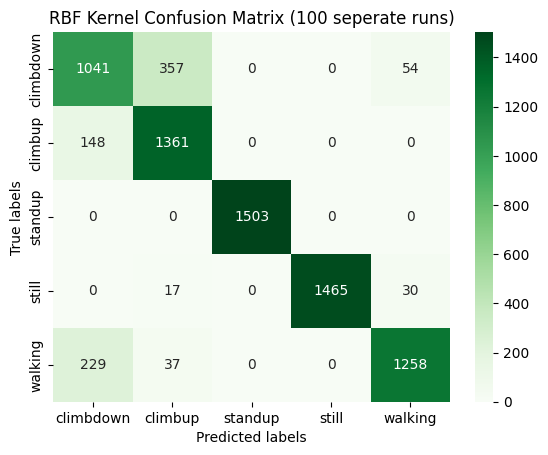

In [234]:
# Training is almost instant so I'll do several runs to get a better idea of the accuracy
avg = 0
runs = 1
classes = ["climbdown", "climbup", "standup", "still", "walking"]
cm_total = np.zeros((5,5))
for x in range(runs):
    xtrain, xtest, ytrain, ytest = train_test_split(featurized_data, labels, test_size=0.3)

    #training the model
    clf = SVC(kernel="linear") #note the default kernel here is 'rbf' - radial basis function
    clf.fit(xtrain, ytrain)
    cv_scores = cross_val_score(clf, xtrain, ytrain, cv=10)

    #testing the model
    ypred = clf.predict(xtest)
    cm = confusion_matrix(ytest, ypred)
    #add the confusion matrix to the total
    cm_total += cm
    cr = classification_report(ytest, ypred)
    
    avg += accuracy_score(ytest, ypred)

#This is what we will be grading (>95 expected)
print('Testing Accuracy:', avg/runs)
print('Average Cross Validation Score from Training:', cv_scores.mean(), sep='\n', end='\n\n\n')
print('Confusion Matrix:', cm_total, sep='\n', end='\n\n\n')
print('Test Statistics:', cr, sep='\n', end='\n\n\n')
# df_cm = pd.DataFrame(cm, index = labels, columns = labels)
ax = plt.subplot()
sns.heatmap(cm_total, annot=True,cmap="Greens", fmt='g', ax=ax).set(title="Linear Kernel Confusion Matrix (1 seperate runs)")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

